In [1]:
#importing libraries
import cv2
import matplotlib.pyplot as plt
import numpy as np

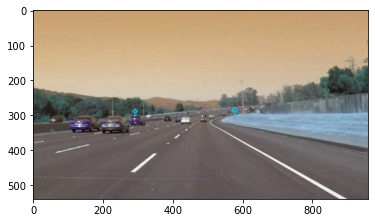

In [2]:
image_path = r"C:\Users\ANUSHKA GARG\Desktop\Lane_detection\images\test_image.jpg"
image1 = cv2.imread(image_path)
plt.imshow(image1)

In [3]:
#converting to grayscale
def grey(image):
    image = np.asarray(image)
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

#Gaussian blur -> Reduce noise and smoothen image
def gauss(image):
    return cv2.GaussianBlur(image, (5,5), 0)

#Canny
def canny(image):
    edges = cv2.Canny(image, 50, 150)
    return edges

In [4]:
def region(image):
    height, width = image.shape
    #isolating the gradients that correspond to the lane lines
    triangle = np.array([
                       [(100, height), (475, 325), (width, height)]
                       ])
    
    #create a black image with the same dimensions as original image
    mask = np.zeros_like(image)
    
    #create a mask (triangle that isolates the region of interest in our image)
    mask = cv2.fillPoly(mask, triangle, 255)
    mask = cv2.bitwise_and(image, mask)
    return mask

In [5]:
def display_lines(image, lines):
    lines_image = np.zeros_like(image)
    
    #to make sure array is not empty
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line
            
            #Black lines on image
            cv2.line(lines_image, (x1, y1), (x2, y2), (255, 0, 0), 10)
        return lines_image

In [6]:
def average(image, lines):
    left = []
    right = []
    for line in lines:
        print(line)
        x1, y1, x2, y2 = lines.reshape(4)
        
        #fit line to points,  return slope and y-int
        parameters = np.polyfit((x1,x2), (y1,y2), 1)
        print(parameters)
        slope = parameters[0]
        y_int = parameters[1]
        
        #lines on the right have positive slope, and lines on the left have negative slope
        if slope < 0:
            left.append((slope, y_int))
        else:
            right.append((slope, y_int))
            
    #average of all the columns (column0: slope, columns: y_int)
    right_avg = np.average(right, axis=0)
    left_avg = np.average(left, axis=0)
    
    #Create line based on avg value
    left_line = make_points(image, left_avg)
    right_line = make_points(image, right_avg)
    return np.array([left_line, right_line])

In [7]:
def make_points(image, average):
    print(average)
    slope, y_int = average
    y1 = image.shape[0]
    
    #length of the line we want --> 3/5 the size of the image
    y2 = int(y1 * (3/5))
    
    #Determine algebraically
    x1 = int((y1 - y_int) // slope)
    x2 = int((y2 - y_int) // slope)
    return np.array([x1, y1, x2, y2])

## Detecting lane lines in image

In [ ]:
copy = np.copy(image1)
edges = cv2.Canny(copy,50,150)
isolated = region(edges)
cv2.imshow("edges", edges)
cv2.imshow("iso", isolated)
cv2.waitKey(0)

#Drawing Lines:(order of params) --> region of interest, bin size (P, theta), min intersections needed, placeholder array
lines = cv2.HoughLinesP(isolated, 2, np.pi/180, 100, np.array([]), minLineLength=40, maxLineGap=5)
averaged_lines = average(copy, lines)
black_lines = display_lines(copy, averaged_lines)

#Taking weighted sum of original image and lane lines image
lanes = cv2.addWeighted(copy, 0.8, black_lines, 1, 1)
cv2.imshow("lanes", lanes)
cv2.waitKey(0)


## Detecting lane lines in video

In [ ]:
video = r"C:\Users\ANUSHKA GARG\Desktop\Lane_detection\video\test2_v2_Trim.mp4"
cap = cv2.VideoCapture(video)
print("here")
num = 0
while(cap.isoOpened()):
    ret, frame = cap.read()
    print(num)
    num += 1
    if ret == True:
        gaus = gauss(frame)
        edges = cv2.Canny(gaus,50,150)
        isolated = region(edges)
        
        #region of interest, bin size (P, theta), min intersections needed, placeholder array
        lines = cv2.HoughLinesP(isolated, 2, np.pi/180, 50, np.array([]), minLineLength=40, maxLineGap=5)
        averaged_lines = average(frame, lines)
        black_lines = display_lines(frame, averaged_lines)
        
        #Weighted of sum of original image and lane lines image
        lanes = cv2.addWeighted(frame, 0.8, black_lines, 1, 1)
        cv2.imshow("frame", lanes)
        if cv2.waitKey(10) & 0xFF == ord('a'):
            break
        else:
            break
            
cap.release()
cv2.destroyAllWindows()